In [3]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

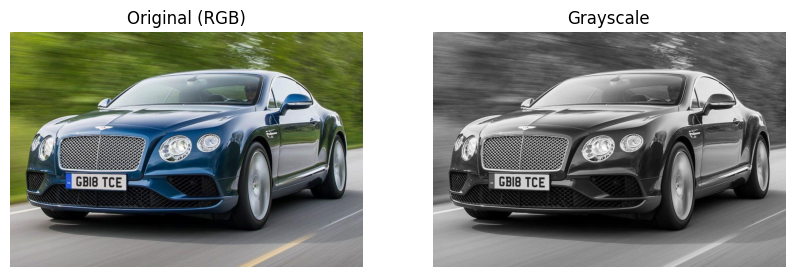

In [4]:
img_color = cv2.imread('1.jpg', 1)

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Convert BGR to RGB for matplotlib display
img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_color_rgb)
plt.title('Original (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

## Section 1

**Mean**: Calculates the average of the adjacent pixels to perform smoothing.

**Median**: Computes the median value of the pixels in the neighborhood and uses that as the new pixel value, which is effective for noise reduction.

**Gaussian**: Filters the image by using a weighted average based on discrete Gaussian values (a bell curve distribution).

As we increase the kernel size, the blur effect gets stronger

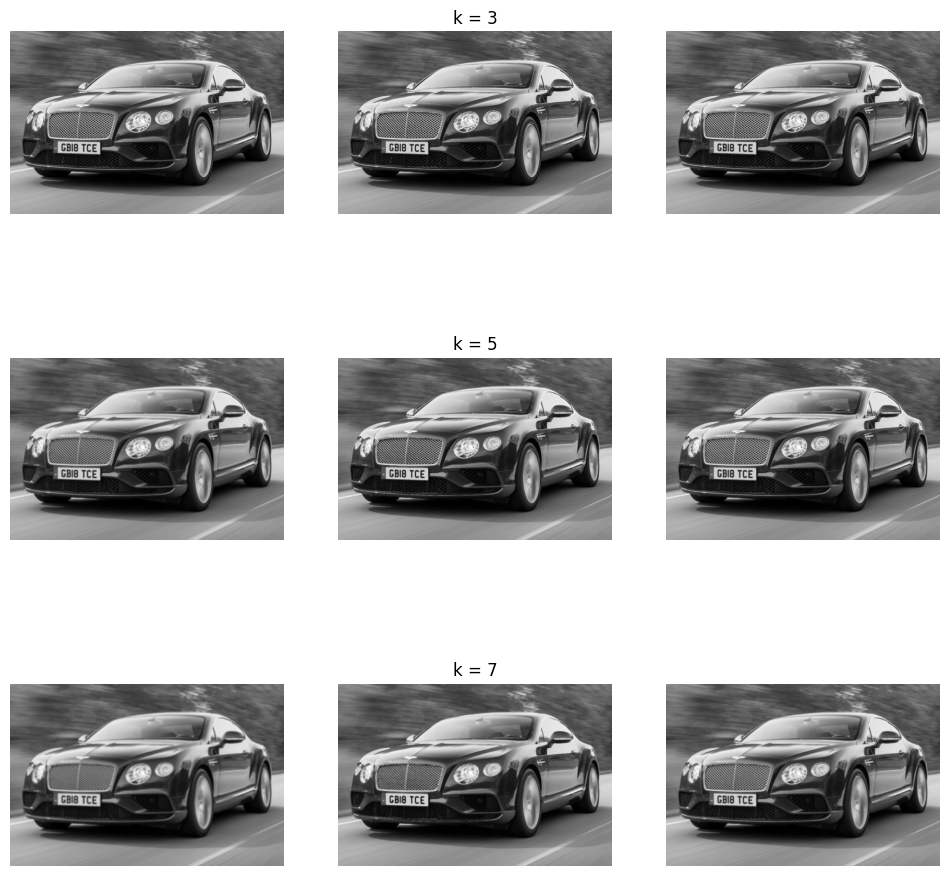

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

i = 0
for k in [3, 5, 7]:
    axes[i].imshow(cv2.blur(img_gray, (k, k)), cmap='gray')
    axes[i].axis('off')

    axes[i+1].title.set_text(f'k = {k}')
    axes[i+1].imshow(cv2.medianBlur(img_gray, k), cmap='gray')
    axes[i+1].axis('off')

    axes[i+2].imshow(cv2.GaussianBlur(img_gray, (k, k), 0), cmap='gray')
    axes[i+2].axis('off')
    i += 3

The Sobel and Prewitt kernels are applied to the image to separately calculate horizontal and vertical edges. For each fitler, the two resulting gradient images are then combined to produce the final edge map of the image.

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

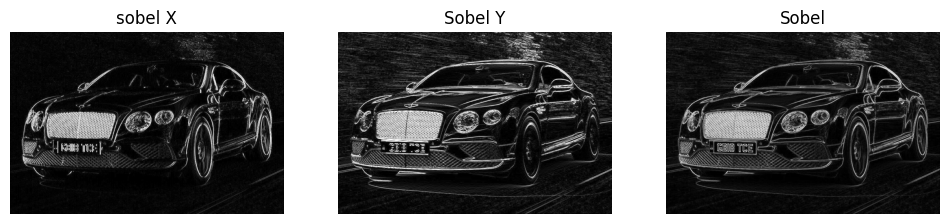

In [6]:
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)

abs_sobelx = cv2.convertScaleAbs(sobelx)
abs_sobely = cv2.convertScaleAbs(sobely)

sobel_combined = cv2.addWeighted(abs_sobelx, 0.5, abs_sobely, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

axes[0].imshow(abs_sobelx, cmap='gray')
axes[0].title.set_text('sobel X')
axes[0].axis('off')

axes[1].imshow(abs_sobely, cmap='gray')
axes[1].title.set_text('Sobel Y')
axes[1].axis('off')

axes[2].imshow(sobel_combined, cmap='gray')
axes[2].title.set_text('Sobel')
axes[2].axis('off')

(np.float64(-0.5), np.float64(1199.5), np.float64(799.5), np.float64(-0.5))

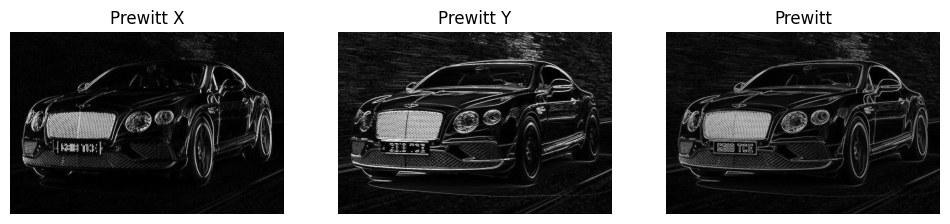

In [7]:
kernelx = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]], dtype=np.float32)

kernely = np.array([[-1, -1, -1],
                    [ 0,  0,  0],
                    [ 1,  1,  1]], dtype=np.float32)


prewittx = cv2.filter2D(img_gray, cv2.CV_64F, kernelx)
prewitty = cv2.filter2D(img_gray, cv2.CV_64F, kernely)

abs_prewittx = cv2.convertScaleAbs(prewittx)
abs_prewitty = cv2.convertScaleAbs(prewitty)

prewitt_combined = cv2.addWeighted(abs_prewittx, 0.5, abs_prewitty, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

axes[0].imshow(abs_prewittx, cmap='gray')
axes[0].title.set_text('Prewitt X')
axes[0].axis('off')

axes[1].imshow(abs_prewitty, cmap='gray')
axes[1].title.set_text('Prewitt Y')
axes[1].axis('off')

axes[2].imshow(prewitt_combined, cmap='gray')
axes[2].title.set_text('Prewitt')
axes[2].axis('off')

The Canny filter is utilized for robust edge detection. As the threshold values are increased, the algorithm becomes more selective, detecting only sharp edges with high contrast and resulting in thinner and more defined edge contours.

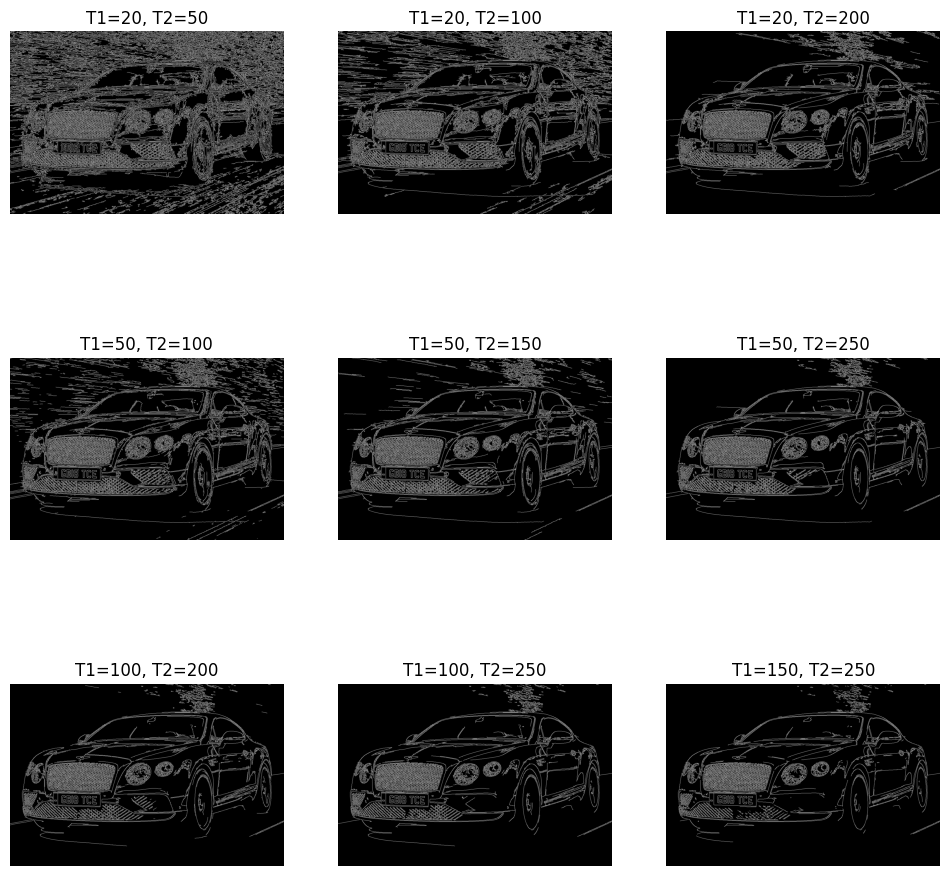

In [8]:
threshold_sets = [
    (20, 50), (20, 100), (20, 200),
    (50, 100), (50, 150), (50, 250),
    (100, 200), (100, 250), (150, 250)
]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, (min_val, max_val) in enumerate(threshold_sets):
    canny_edges = cv2.Canny(img_gray, min_val, max_val)

    ax = axes[i]
    ax.imshow(canny_edges, cmap='gray')
    ax.set_title(f'T1={min_val}, T2={max_val}')
    ax.axis('off')

The image and the video are loaded, and their shapes (dimensions) are verified for compatibility.

In [36]:
bg_image = cv2.imread('image.jpg')
cap = cv2.VideoCapture('video.mp4')

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_dims = (frame_width, frame_height)
print(f"Video resolution: {video_dims[0]}x{video_dims[1]}")

if bg_image.shape[:2] != (frame_height, frame_width):
    print("Resizing background image to match video dimensions...")
    bg_image_resized = cv2.resize(bg_image, video_dims)
else:
    bg_image_resized = bg_image.copy()

Video resolution: 1280x720


Different threshold values and kernel sizes were tested on several video frames to design the processing mask. Additionally, the image brightness was adjusted to correct for the discrepancy between still image capture and video recording settings.

Non-zero mask pixels: 191633


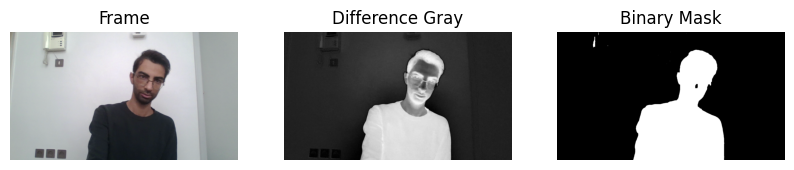

In [37]:
BRIGHTNESS_BOOST = 40
THRESHOLD_VALUE = 45

ret, test_frame = cap.read()

test_frame = cv2.resize(test_frame, (frame_width, frame_height))
brighter_image = cv2.add(bg_image, np.ones(bg_image.shape, dtype="uint8") * BRIGHTNESS_BOOST)

diff = cv2.absdiff(test_frame, brighter_image)
gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

dilated_mask = cv2.dilate(mask, kernel, iterations=1)
eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

print("Non-zero mask pixels:", cv2.countNonZero(mask))

# Show sample output
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB)); plt.title("Frame"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gray, cmap='gray'); plt.title("Difference Gray"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(eroded_mask, cmap='gray'); plt.title("Binary Mask"); plt.axis('off')
plt.show()

Finally, a mask is generated for each video frame and then applied to perform the necessary operation.

In [38]:
MIN_PIXELS = 5000
sampled_frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame is None:
        break

    if frame.shape[1] != frame_width or frame.shape[0] != frame_height:
        frame = cv2.resize(frame, (frame_width, frame_height))

    diff = cv2.absdiff(frame, brighter_image)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY)

    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    eroded_mask = cv2.erode(dilated_mask, kernel, iterations=1)

    result = cv2.bitwise_and(frame, frame, mask=eroded_mask)

    if cv2.countNonZero(mask) > MIN_PIXELS:
        if isinstance(frame, np.ndarray):
            sampled_frames.append(result)

cap.release()

print("Valid frames collected:", len(sampled_frames))


if len(sampled_frames) > 0:
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter("output_video.mp4", fourcc, 30, (frame_width, frame_height))

    for f in sampled_frames:
        out.write(f)

    out.release()
    print("DONE → output_video.mp4 created!")
else:
    print("valid frames to write")


Valid frames collected: 151
DONE → output_video.mp4 created!
